# A Customised CNN Model to diagnose the clusters

#### A subset of images from the dataset are  segregated and then classified into four labels. A small sample from the labels are given below. Unclear and blank images are labeled as noises.

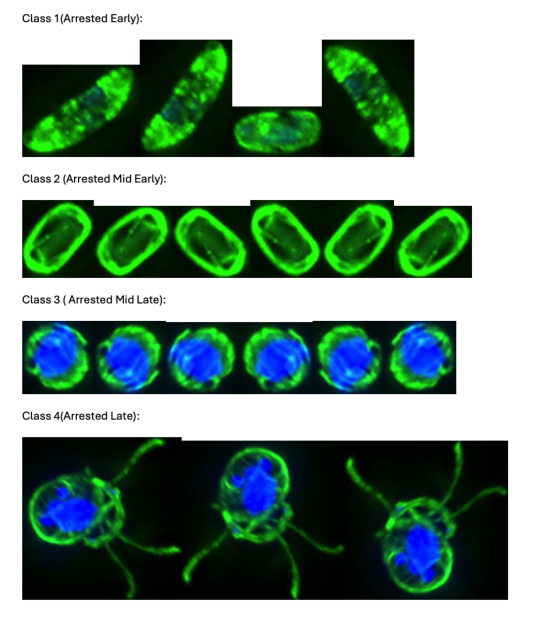

In [17]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
image_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/Screenshot 2024-07-17 at 11.25.06 pm.png'
img = Image.open(image_path)

# Display the image in the notebook
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


The segregated dataset is now being feed into a convolutional neural network(CNN) with four hidden layers fully connected. The model is being trained with 15 epochs and learning rate at 0.001. The dataset is split into training(70%) and validation(30%) dataset.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define CNN Model with three hidden layers
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)  # Third hidden layer
        self.fc3 = nn.Linear(256, 128)  # Fourth hidden layer
        self.fc4 = nn.Linear(128, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.maxpool1(self.relu(self.conv1(x)))
        x = self.maxpool1(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.maxpool2(self.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # Third hidden layer
        x = self.relu(self.fc3(x))  # Fourth hidden layer
        x = self.fc4(x)
        return x

# Helper function -- Define top-k accuracy
def calculate_topk_accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0].item()  # return top-1

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
custom_dataset = ImageFolder(root='/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/Training_Data', transform=transform)

# Split the dataset
def create_data_loaders(dataset, test_ratio=0.2, batch_size=32, seed=0):
    torch.manual_seed(seed)
    val_size = int(len(dataset) * test_ratio)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, val_loader

train_loader, val_loader = create_data_loaders(custom_dataset, test_ratio=0.2, batch_size=32, seed=0)

# Instantiate the model. loss function, and optimizer
custom_model = CustomCNN()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001) 
loss_function = nn.CrossEntropyLoss()

# Train and Val
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 15

for epoch in range(num_epochs):
    custom_model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = custom_model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        accuracy_percent = calculate_topk_accuracy(output, target, topk=(1,))
        total_correct += accuracy_percent / 100.0 * target.size(0)  # Convert percentages to the number of samples
        total_samples += target.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Val
    custom_model.eval()
    val_loss, val_correct, val_samples = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            output = custom_model(data)
            loss = loss_function(output, target)

            val_loss += loss.item()
            accuracy_percent = calculate_topk_accuracy(output, target, topk=(1,))
            val_correct += accuracy_percent / 100.0 * target.size(0)  # Convert percentages to the number of samples
            val_samples += target.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch 1: Train Loss: 1.5550, Train Accuracy: 32.12%, Val Loss: 1.1553, Val Accuracy: 44.14%
Epoch 2: Train Loss: 0.6519, Train Accuracy: 76.78%, Val Loss: 0.4002, Val Accuracy: 87.70%
Epoch 3: Train Loss: 0.4128, Train Accuracy: 85.53%, Val Loss: 0.2646, Val Accuracy: 91.02%
Epoch 4: Train Loss: 0.2788, Train Accuracy: 90.24%, Val Loss: 0.2986, Val Accuracy: 90.04%
Epoch 5: Train Loss: 0.2045, Train Accuracy: 91.78%, Val Loss: 0.2633, Val Accuracy: 91.02%
Epoch 6: Train Loss: 0.1665, Train Accuracy: 93.94%, Val Loss: 0.1478, Val Accuracy: 94.34%
Epoch 7: Train Loss: 0.1343, Train Accuracy: 95.43%, Val Loss: 0.0921, Val Accuracy: 97.66%
Epoch 8: Train Loss: 0.1093, Train Accuracy: 95.67%, Val Loss: 0.1464, Val Accuracy: 95.90%
Epoch 9: Train Loss: 0.0982, Train Accuracy: 96.49%, Val Loss: 0.1119, Val Accuracy: 96.88%
Epoch 10: Train Loss: 0.0876, Train Accuracy: 97.45%, Val Loss: 0.0834, Val Accuracy: 97.85%
Epoch 11: Train Loss: 0.0952, Train Accuracy: 97.16%, Val Loss: 0.1597, Val Acc

### Checking the loss and accuracy for the model

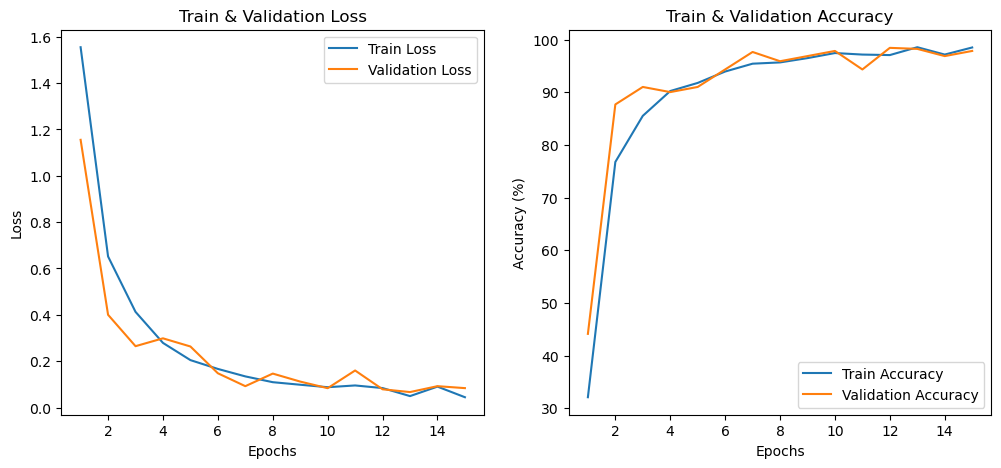

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1,num_epochs+1),train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1),val_losses, label='Validation Loss')
plt.title('Train & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,num_epochs+1),train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1),val_accuracies, label='Validation Accuracy')
plt.title('Train & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

### Confusion Matrix for Training Dataset

In [26]:
classes = ("Arrested Early","Arrested Mid 1","Arrested Mid 2","Arrested Late","Unclear/Noise")

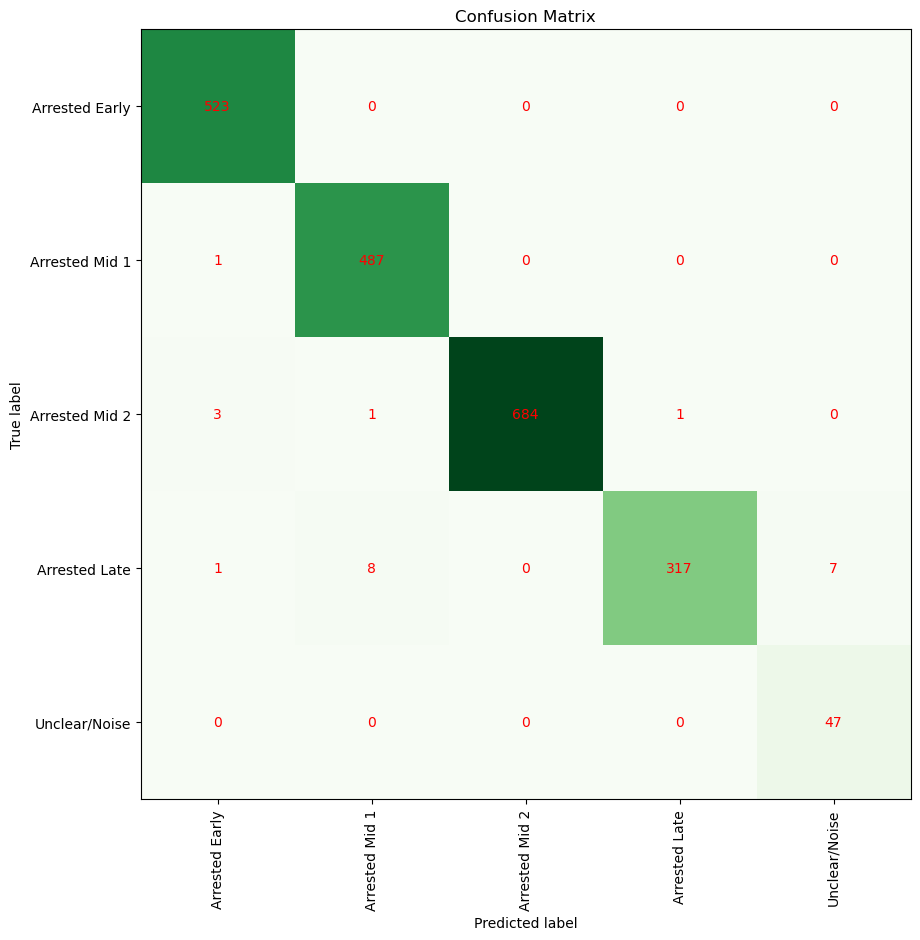

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_confusion_matrix(model, loader):
    y_actual = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            _, predicted = torch.max(preds, 1)
            y_actual += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()
            #all_preds = torch.cat((all_preds, preds), dim=0)
    cm = confusion_matrix(y_actual, y_pred)
    return cm 

train_cm = get_confusion_matrix(custom_model, train_loader)
validation_cm = get_confusion_matrix(custom_model, val_loader)

def plot_confuion_matrix(cm):
    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.imshow(cm,cmap='Greens')
    ax1.set_title('Confusion Matrix')
    ax1.set_xticks(np.arange(5))
    ax1.set_yticks(np.arange(5))
    ax1.set_xticklabels(classes, rotation = 90)
    ax1.set_yticklabels(classes)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax1.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')
    plt.show()
    
plot_confuion_matrix(train_cm)

### Confusion Matrix for Validation Dataset

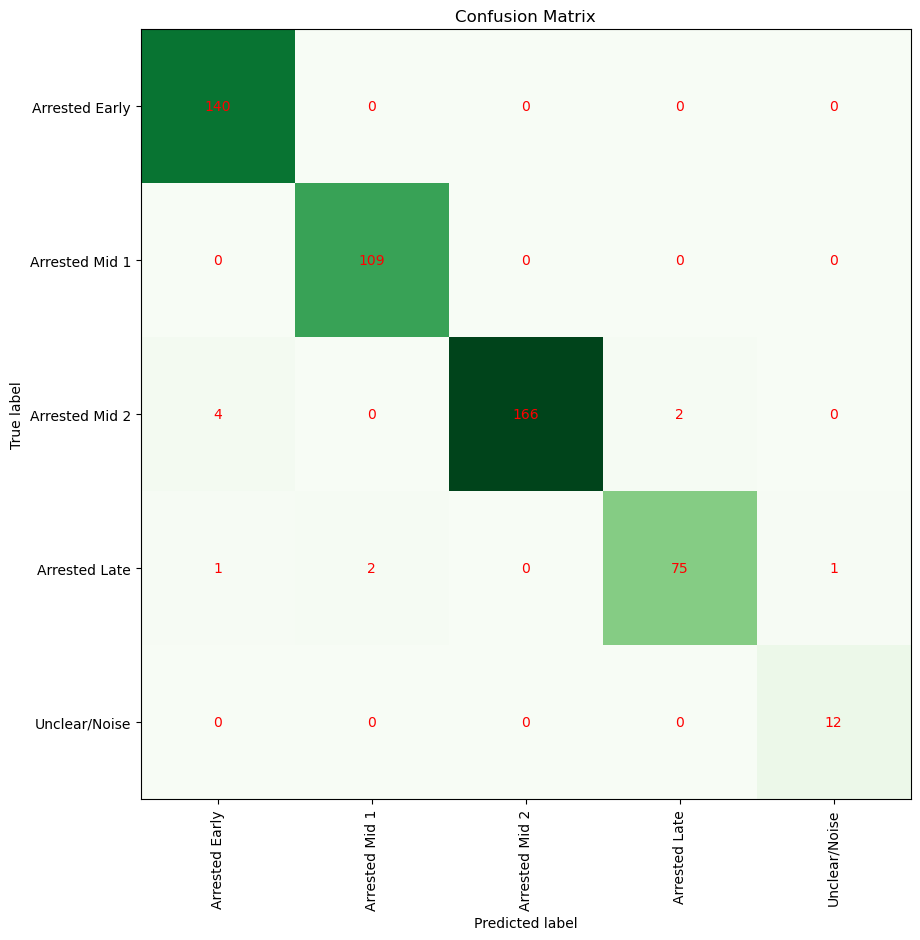

In [28]:
plot_confuion_matrix(validation_cm)

### Saving the model weights as checkpoints

In [29]:
# Save the checkpoint
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': custom_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}
torch.save(checkpoint, '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/final_model_checkpoint.pth')

print("Checkpoint saved successfully.")


Checkpoint saved successfully.


# Using the model to analsye the clusters

The model is now used to analyse the clusters from the kmeans model which had dimensionality redcution using umap. The clusters are visualised below.

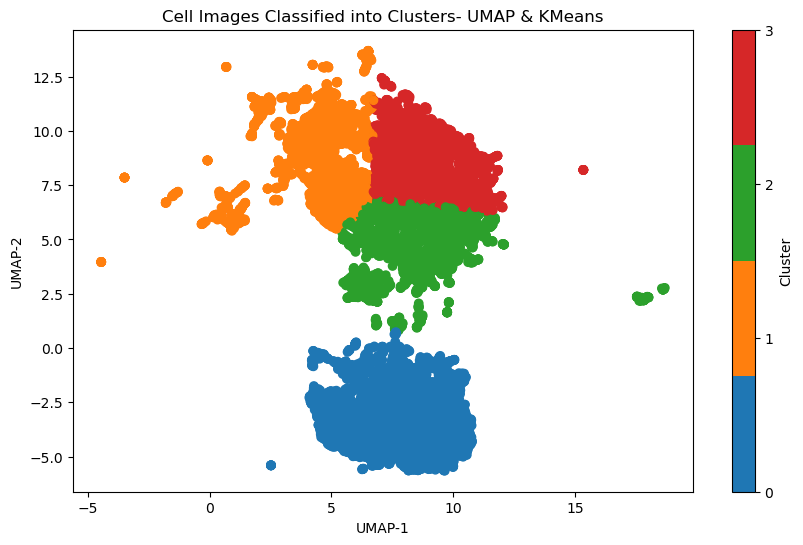

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


data= pd.read_csv("/Users/vishanthsuresh/Downloads/Data Science/Dissertation/PhIDDLI-main/data/routput_UMAP_Kmeans_new.csv")
# Define a set of more contrasting and visually distinct colors
contrasting_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c','#d62728'
]

# Create a colormap from the list of contrasting colors
custom_cmap_contrasting = mcolors.ListedColormap(contrasting_colors[:15])

# Plotting point_x and point_y with clusters in different colors using the custom colormap
plt.figure(figsize=(10, 6))

# Using a scatter plot to visualize the clusters
scatter = plt.scatter(data['point_x'], data['point_y'], c=data['cluster'], cmap=custom_cmap_contrasting)

# Adding a color bar to indicate the cluster colors
cbar = plt.colorbar(scatter, label='Cluster', ticks=range(15))
cbar.set_ticklabels(range(15))

# Adding titles and labels
plt.title('Cell Images Classified into Clusters- UMAP & KMeans')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

# Display the plot
plt.show()


### Analysing the Cluster 0 

Results saved to prediction_results.csv


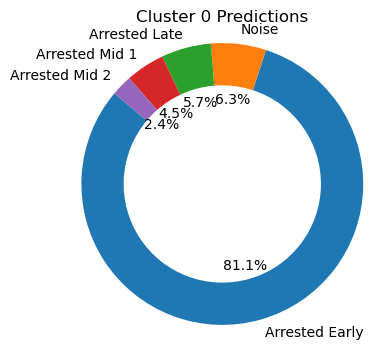

In [44]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Define CNN Model with three hidden layers (same as before)
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)  # Third hidden layer
        self.fc3 = nn.Linear(256, 128)  # Fourth hidden layer
        self.fc4 = nn.Linear(128, 30)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.maxpool1(self.relu(self.conv1(x)))
        x = self.maxpool1(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.maxpool2(self.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # Third hidden layer
        x = self.relu(self.fc3(x))  # Fourth hidden layer
        x = self.fc4(x)
        return x

# Load the checkpoint
checkpoint = torch.load('/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/final_model_checkpoint.pth')
model = CustomCNN()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define the transformation for the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Arrested Mid 1',
    1: 'Arrested Mid 2',
    2: 'Arrested Early',
    3: 'Arrested Late',
    4: 'Noise'
    # Add other class mappings as necessary
}

# Function to predict image
def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
    _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

# Directory containing new images
new_images_folder = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/cluster_0'

# Predict on the new images and store the results
results = []
for image_name in os.listdir(new_images_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
        image_path = os.path.join(new_images_folder, image_name)
        predicted_class = predict_image(image_path, model, transform)
        results.append({'Image': image_name, 'Predicted_Class': predicted_class})

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/Cluster_0.csv', index=False)
print("Results saved to prediction_results.csv")

# Generate a donut chart
class_counts = results_df['Predicted_Class'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Cluster 0 Predictions')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()


#### The cluster 0 shows most of the images from arrested early(coffee bean shaped gametocytes) moreover it is a pretty well suited cluster as it looks quite well separated from other clusters in the clusters visualisation

### Analysing the Cluster 1

Results saved to prediction_results.csv


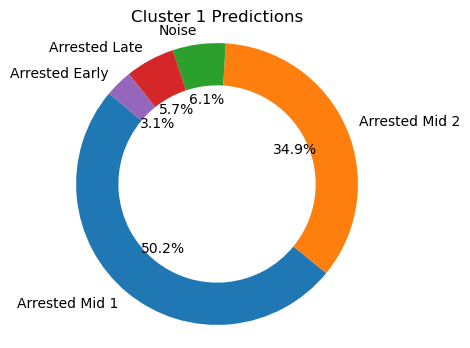

In [48]:
# Directory containing new images
new_images_folder = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/cluster_1'

# Predict on the new images and store the results
results = []
for image_name in os.listdir(new_images_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
        image_path = os.path.join(new_images_folder, image_name)
        predicted_class = predict_image(image_path, model, transform)
        results.append({'Image': image_name, 'Predicted_Class': predicted_class})

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/Cluster_1.csv', index=False)
print("Results saved to prediction_results.csv")

# Generate a donut chart
class_counts = results_df['Predicted_Class'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Cluster 1 Predictions')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()


#### Cluster 1 shows most of the images from arrested mid1 (early) and arrested mid2(late) holds the second place. It still has most of the arrested mid 1 images , however the mix of the another class happened as cluster 1,2 and 3 got sticked together in the model visualisation.

## Analysing Cluster 2

Results saved to prediction_results.csv


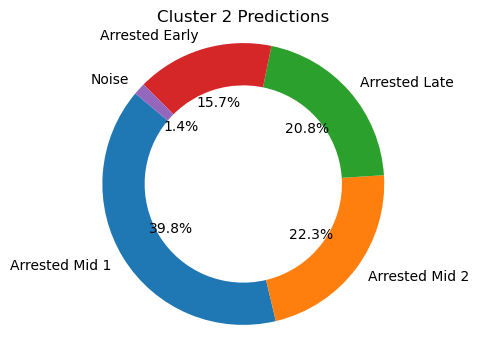

In [42]:
# Directory containing new images
new_images_folder = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/cluster_2'

# Predict on the new images and store the results
results = []
for image_name in os.listdir(new_images_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
        image_path = os.path.join(new_images_folder, image_name)
        predicted_class = predict_image(image_path, model, transform)
        results.append({'Image': image_name, 'Predicted_Class': predicted_class})

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/Cluster_2.csv', index=False)
print("Results saved to prediction_results.csv")

# Generate a donut chart
class_counts = results_df['Predicted_Class'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Cluster 2 Predictions')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()


#### None of the classes had a majority here and needs attention. However this is the cluster where most of the arrested late(exflaggerated gametocytes) got placed.

### Analysing Cluster 3

Results saved to prediction_results.csv


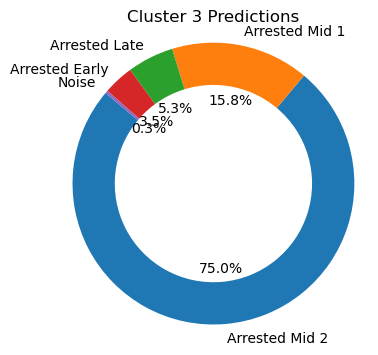

In [43]:
# Directory containing new images
new_images_folder = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/cluster_3'

# Predict on the new images and store the results
results = []
for image_name in os.listdir(new_images_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add other image extensions if needed
        image_path = os.path.join(new_images_folder, image_name)
        predicted_class = predict_image(image_path, model, transform)
        results.append({'Image': image_name, 'Predicted_Class': predicted_class})

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('/Users/vishanthsuresh/Downloads/Data Science/Dissertation/CNN Model/clusters_umap_kmeans/Cluster_3.csv', index=False)
print("Results saved to prediction_results.csv")

# Generate a donut chart
class_counts = results_df['Predicted_Class'].value_counts()
plt.figure(figsize=(4,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Cluster 3 Predictions')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()


#### This Cluster holds arrested mid2(late) as the major class here. 

## Labeling the Clusters

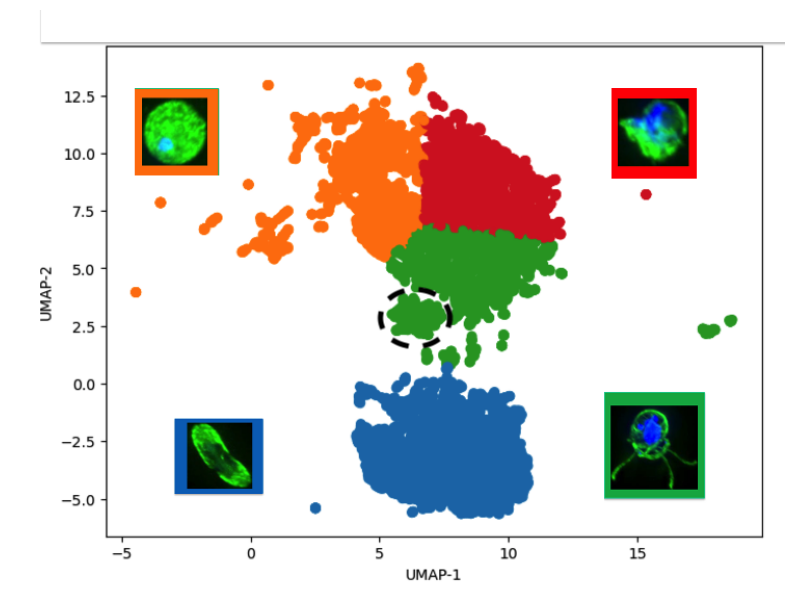

In [51]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
image_path = '/Users/vishanthsuresh/Downloads/Data Science/Dissertation/Screenshot 2024-07-07 at 10.03.28 pm.png'
img = Image.open(image_path)

# Display the image in the notebook
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()

## Note:
1. Only the Green Cluster has most of the exflaggerated images. The exflaggerated images lie on the circled region in the image which forms a separate cluster from the rest of the green points. However the algorithm calculated all the green points as a single cluster which has to be rectified.